In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
from collections import OrderedDict
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix  
from collections import Counter
import random


plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("You are using CUDA")

You are using CUDA


In [2]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [3]:
data_dir = '../input/kimoanh29/DATA_CHAMBER_2021'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

In [4]:
## Make sure the input data is resized to 224x224 pixels.

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.Grayscale(3),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: ImageFolderWithPaths(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in ['train', 'test']
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=2
    )
    for x in ['train', 'test']
}
pathloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x].imgs, batch_size=8,
        shuffle=True, num_workers=2
    )
    for x in ['train', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train',  'test']}

#Check cuda
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print(device)

cuda


In [5]:
for x in ['train', 'test']:
    print("Loaded {} images in {}".format(dataset_sizes[x], x))
    
print("Classes: ")

label = image_datasets['train'].classes
print(image_datasets['train'].classes)

Loaded 6717 images in train
Loaded 1607 images in test
Classes: 
['2C', '3C', '4C']


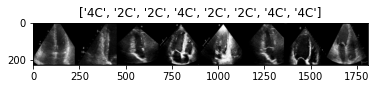

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[label[x] for x in classes])


# Get a batch of training data
inputs, classes,_ = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[label[x] for x in classes])

In [7]:
torch.__version__

'1.9.1'

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    
    # Set model for evaluation
    model.train(False)
    model.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders['test']):
        inputs, labels,_ = data
        size = inputs.size()[0]
        
        if use_gpu:
            with torch.no_grad():
                inputs, labels = inputs.cuda(), labels.cuda()
        else:
            with torch.no_grad():
                inputs, labels = inputs, labels
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    model.train(mode=was_training)

In [9]:
def eval_model(model, criterion):
    y_true = []
    y_pred = []
    vid_id = []
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders['test'])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders['test']):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        model.train(False)
        model.eval()
        
        inputs, labels, fname = data
        
        for f in fname:
            vid_id.append(f.split('/')[-1].split('.')[0].split('_')[0])
        y_true = y_true + labels.tolist()
        
        if use_gpu:
            with torch.no_grad():
                inputs, labels = inputs.cuda(), labels.cuda()
        else:
            with torch.no_grad():
                inputs, labels = inputs, labels

        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        #print(preds)
        y_pred = y_pred + preds.tolist()
        
        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes['test']
    avg_acc = acc_test / dataset_sizes['test']
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)
    return y_true,y_pred,vid_id

In [10]:
model = models.vgg19_bn()
model.load_state_dict(torch.load("../input/vgg19bn/vgg19_bn.pth"))
print(model.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in model.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(label))]) # Add our layer with 4 outputs
model.classifier = nn.Sequential(*features) # Replace the model classifier

1000


In [11]:
# If you want to train the model for more than 2 epochs, set this to True after the first run
resume_training = False

if resume_training:
    print("Loading pretrained model..")
    model.load_state_dict(torch.load('../input/vgg16-transfer-learning-pytorch/VGG16_v2-OCT_Retina.pt'))
    print("Loaded!")
    
if use_gpu:
    model.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
print("Test before training")
eval_model(model, criterion)
print('')

Test before training
Evaluating model
----------
Test batch 200/201
Evaluation completed in 0m 24s
Avg loss (test): 0.1373
Avg acc (test): 0.3815
----------



Ground truth:


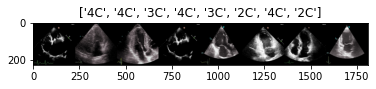

Prediction:


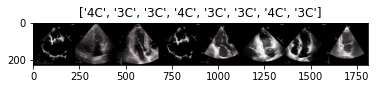

In [13]:
visualize_model(model) #test before training

**Training model**

In [14]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders['train'])
    
    loss_values = []
    acc_values = []
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders['train']):
            
            print("\rTraining batch {}/{}".format(i+1, train_batches), end='', flush=True)
                
            
                
            inputs, labels,_= data
            
            if use_gpu:
                with torch.no_grad():
                    inputs, labels = inputs.cuda(), labels.cuda()
            else:
                with torch.no_grad():
                    inputs, labels = inputs, labels
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train  / dataset_sizes['train']
        avg_acc = acc_train  / dataset_sizes['train']
        loss_values.append(avg_loss)
        acc_values.append(avg_acc)
        vgg.train(False)
        vgg.eval()
            

        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))

        print('-' * 10)
        print()
        
        if avg_acc > best_acc:
            best_acc = avg_acc
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg,acc_values,loss_values

In [15]:
model,acc,loss = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
torch.save(model.state_dict(),'VGG19_echocardiogram.pt')

Epoch 0/10
----------
Training batch 840/840

Epoch 0 result: 
Avg loss (train): 0.0759
Avg acc (train): 0.7279
----------

Epoch 1/10
----------
Training batch 840/840

Epoch 1 result: 
Avg loss (train): 0.0416
Avg acc (train): 0.8626
----------

Epoch 2/10
----------
Training batch 840/840

Epoch 2 result: 
Avg loss (train): 0.0315
Avg acc (train): 0.8959
----------

Epoch 3/10
----------
Training batch 840/840

Epoch 3 result: 
Avg loss (train): 0.0259
Avg acc (train): 0.9153
----------

Epoch 4/10
----------
Training batch 840/840

Epoch 4 result: 
Avg loss (train): 0.0241
Avg acc (train): 0.9235
----------

Epoch 5/10
----------
Training batch 840/840

Epoch 5 result: 
Avg loss (train): 0.0215
Avg acc (train): 0.9293
----------

Epoch 6/10
----------
Training batch 840/840

Epoch 6 result: 
Avg loss (train): 0.0182
Avg acc (train): 0.9418
----------

Epoch 7/10
----------
Training batch 840/840

Epoch 7 result: 
Avg loss (train): 0.0203
Avg acc (train): 0.9378
----------

Epoch 8/

In [16]:
y_true,y_pred,vid_code = eval_model(model, criterion)

Evaluating model
----------
Test batch 200/201
Evaluation completed in 0m 17s
Avg loss (test): 0.1172
Avg acc (test): 0.8475
----------


Ground truth:


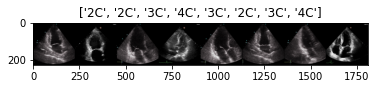

Prediction:


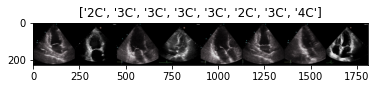

Ground truth:


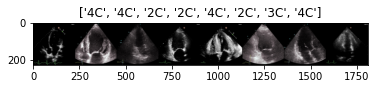

Prediction:


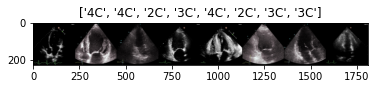

Ground truth:


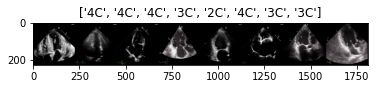

Prediction:


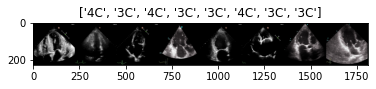

In [17]:
visualize_model(model, num_images = 24)

plt.ioff()
plt.show()

In [18]:
from sklearn.metrics import accuracy_score,classification_report
import pandas as pd
import glob

#check data
df = pd.DataFrame(list(zip(y_true,y_pred,vid_code)),columns =['y_true','y_pred','video_id'])
df.to_csv('df.csv',encoding='utf-8',index=False)
df.head(29)

,y_true,y_pred,video_id
0,0,0,192
1,2,2,170
2,1,1,161
3,2,2,160
4,2,2,193
5,0,0,176
6,1,1,186
7,2,2,163
8,2,1,167
9,0,0,171


In [19]:
from statistics import mode
vid_list = list(set(df['video_id'].values))

total = len(vid_list)
print("The number of videos is {} \n".format(total))
print(vid_list)

The number of videos is 39 

['175', '185', '191', '188', '157', '163', '162', '169', '178', '187', '158', '177', '194', '186', '180', '172', '181', '192', '193', '168', '171', '159', '173', '166', '179', '195', '174', '167', '164', '189', '161', '160', '183', '182', '184', '165', '176', '170', '190']


In [20]:
y_true = []
y_pred = []
for vid in vid_list:
    #print(vid)
    tmp_df = df[df['video_id'] == vid]
    #print(len(tmp_df))
    vid_pred = tmp_df['y_pred'].mode().values[0]
    vid_label = tmp_df['y_true'].mode().values[0]
    y_true.append(vid_label)
    y_pred.append(vid_pred)

Video prediction results based on voting predicted frame's labels

In [21]:
accuracy_score(y_true,y_pred)

0.8974358974358975

* CHART

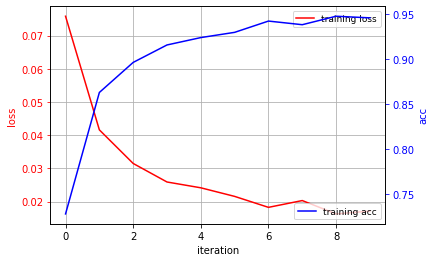

In [22]:
def plot_history(history,loss,acc): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(loss, 'r', label="training loss")
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('loss', color='r')
    ax1.legend(loc="best", fontsize=9)    
    ax1.tick_params('y', colors='r')

    ax2 = ax1.twinx()
    ax2.plot(acc, 'b', label="training acc")
    ax2.legend(loc="lower right", fontsize=9)
    ax2.set_ylabel('acc', color='b')        
    ax2.tick_params('y', colors='b')
plot_history(model,loss,acc)